# Checking if a pair of stocks is cointegrated

## Setup

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached yfinance-0.2.52-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata 

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

import yfinance as yf


/Users/mescobars/dev/projects/GitHub/pairs-trading/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Set plotting options
%matplotlib inline
plt.rc('figure', figsize=(16, 9))

## Project Helper Functions

In [4]:
def analyze_dataset(dataset):
    """
    Analyzes a given dataset and prints information about each column.

    Args:
        dataset (pd.DataFrame): The input dataset.

    Returns:
        None
    """
    print(type(dataset))
    # Get column names
    columns = dataset.columns

    # Print column information
    for col in columns:
        dtype = dataset[col].dtype
        num_nan = dataset[col].isna().sum()
        num_zeros = (dataset[col] == 0).sum()

        print(f"Column: {col}")
        print(f"  Data Type: {dtype}")
        print(f"  NaN Values: {num_nan}")
        print(f"  Zero Values: {num_zeros}\n")

In [5]:
def format_column_names(df):
    """The functions returns a data frame with its formatted columns"""
    # Convert column names to lowercase
    df.rename(columns=str.lower, inplace=True)
    
    # Replace spaces with underscores
    df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
    
    # Replace hyphens with underscores
    df.rename(columns=lambda x: x.strip().replace("-", "_"), inplace=True)
    
    return df

In [7]:
def fetch_yf(tickers, start_date, end_date):
    df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
    df.reset_index(inplace=True)
    df = format_column_names(df)
    df['date'] = pd.to_datetime(df['date'])
    
    return df

## Data Importing and Processing

In [28]:
# fetching parameters
start_date = '2014-12-31'
end_date = '2024-12-31'

# yf tickers for pairs trading candidates
#tickers = ['BZ=F', 'CL=F']
tickers = ['AUDUSD=X', 'NZDUSD=X']

data = fetch_yf(tickers, start_date, end_date)

data.fillna(method='ffill', inplace=True)

print(analyze_dataset(data))
data.head(5)


[*********************100%***********************]  2 of 2 completed
/var/folders/18/blnm1nm50696kqjfj926l25r0000gn/T/ipykernel_6825/932584155.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


<class 'pandas.core.frame.DataFrame'>
Column: date
  Data Type: datetime64[ns]
  NaN Values: 0
  Zero Values: 0

Column: audusd=x
  Data Type: float64
  NaN Values: 0
  Zero Values: 0

Column: nzdusd=x
  Data Type: float64
  NaN Values: 0
  Zero Values: 0

None


Ticker,date,audusd=x,nzdusd=x
0,2014-12-31,0.818398,0.783515
1,2015-01-01,0.817127,0.780092
2,2015-01-02,0.817795,0.779180
3,2015-01-05,0.806777,0.766577
4,2015-01-06,0.809979,0.770001


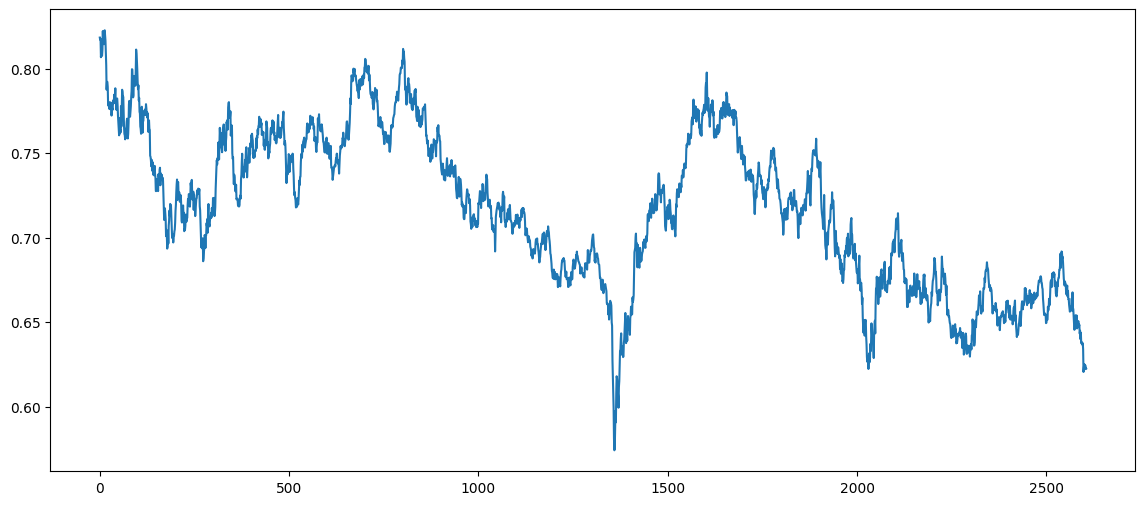

In [29]:
s1 = pd.Series(data['audusd=x'])
s1.plot(figsize=(14,6))
plt.show()

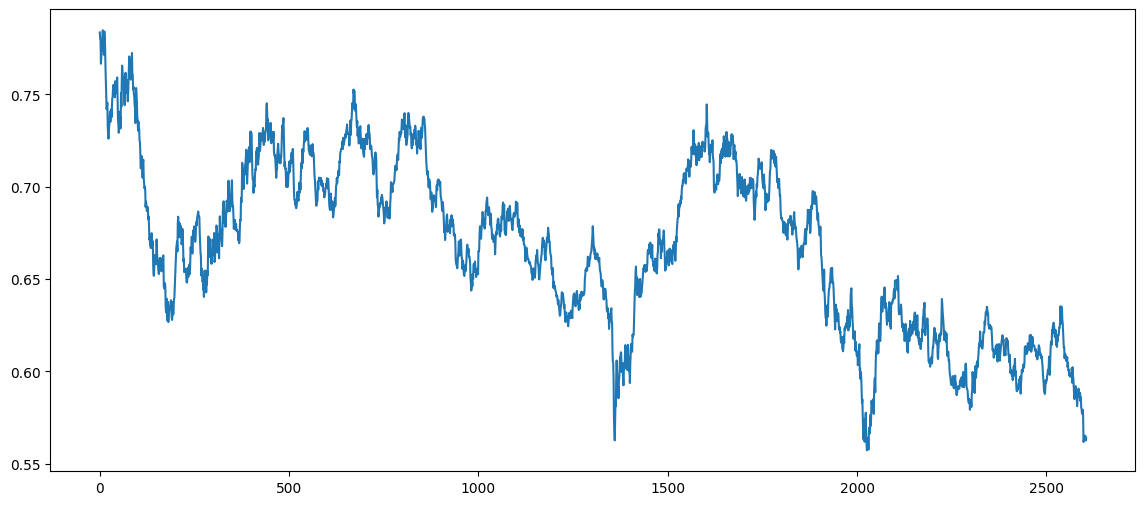

In [30]:
s2 = pd.Series(data['nzdusd=x'])
s2.plot(figsize=(14,6))
plt.show()

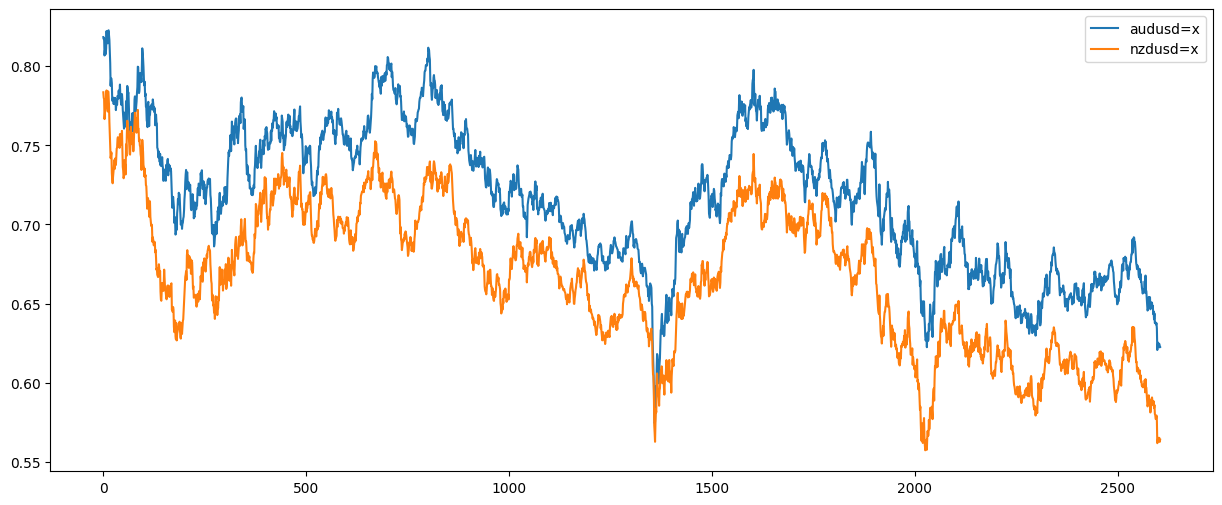

In [31]:
pd.concat([s1, s2], axis=1).plot(figsize=(15,6))
plt.show()

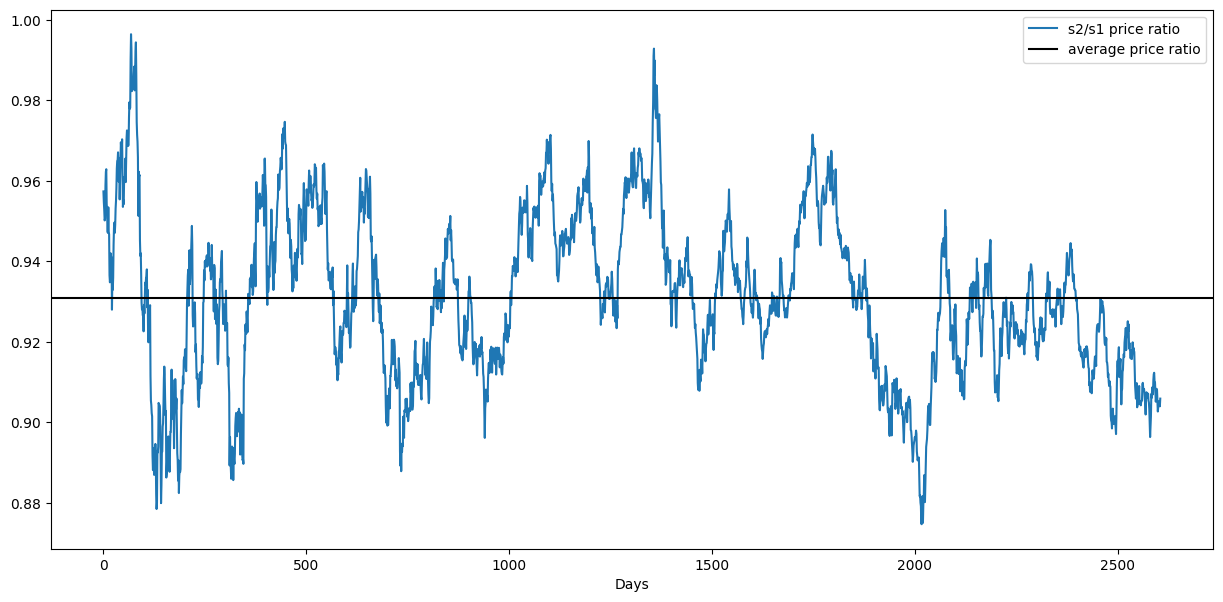

average price ratio 0.9310


In [32]:
price_ratio = s2/s1
price_ratio.plot(figsize=(15,7)) 
plt.axhline(price_ratio.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['s2/s1 price ratio', 'average price ratio'])
plt.show()
print(f"average price ratio {price_ratio.mean():.4f}")

## Calculate hedge ratio with regression

### Linear Regression

Note that the LinearRegression().fit() expects 2D numpy arrays.  Since s1 and s2 are pandas series, we can use Series.values to get the values as a numpy array. Since these are 1D arrays, we can use numpy.reshape(-1,1) to make these 1000 row by 1 column 2 dimensional arrays

In [33]:
print(type(s1))
print(type(s1.values))
print(s1.values.reshape(-1,1).shape)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(2606, 1)


In [34]:
lr = LinearRegression()
lr.fit(s1.values.reshape(-1,1),s2.values.reshape(-1,1))

LinearRegression()

In [36]:
hedge_ratio = lr.coef_[0][0]
hedge_ratio

np.float64(0.9609953854308783)

In [37]:
intercept = lr.intercept_[0]
intercept

np.float64(-0.021447184065505498)

In [38]:
print(f"hedge ratio from regression is {hedge_ratio:.4f}, intercept is {intercept:.4f}")

hedge ratio from regression is 0.9610, intercept is -0.0214


### Calculate the spread without the intercept 

In [39]:
spread = s2 - s1 * hedge_ratio

In [40]:
print(f"Average spread is {spread.mean()}")

Average spread is -0.02144718406550553


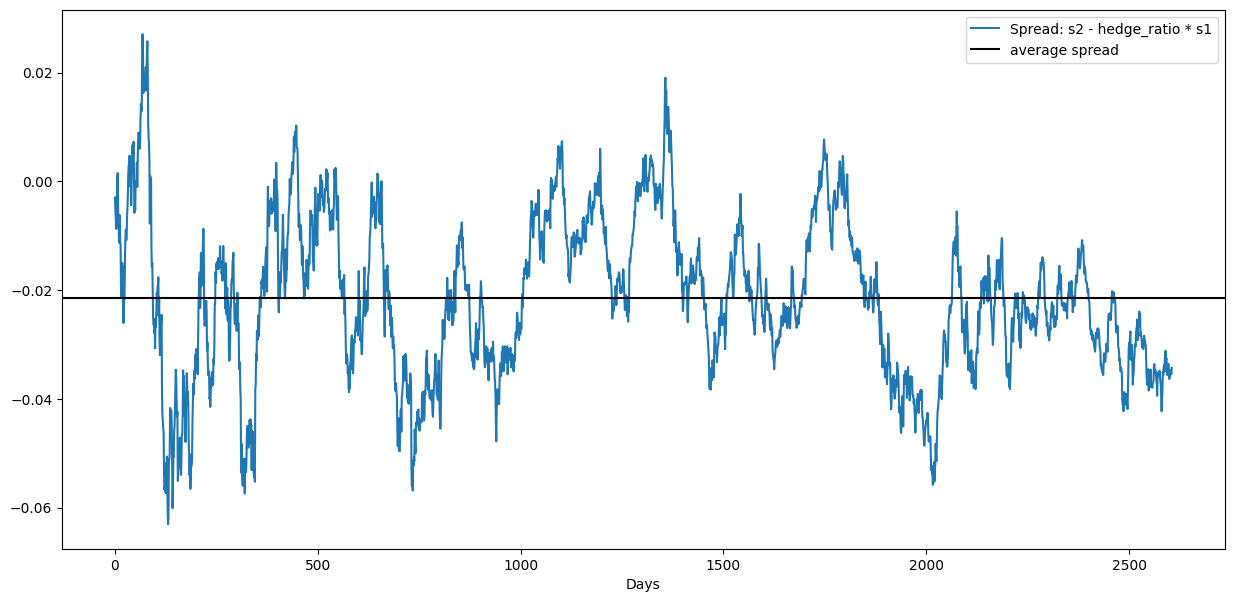

In [41]:
spread.plot(figsize=(15,7)) 
plt.axhline(spread.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['Spread: s2 - hedge_ratio * s1', 'average spread'])
plt.show()

### Calculate the spread with the Intercept

In [44]:
spread_with_intercept = s2 - (s1 * hedge_ratio + intercept)
print(f"Average spread with intercept included is {spread_with_intercept.mean():.10f}")


Average spread with intercept included is -0.0000000000


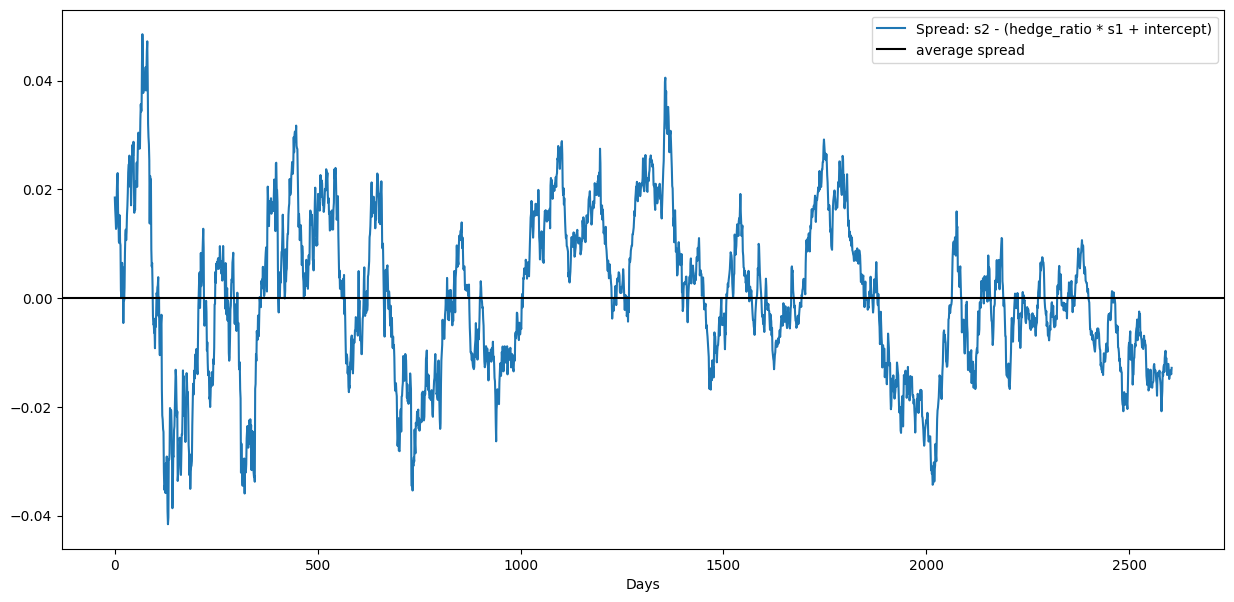

In [45]:
spread_with_intercept.plot(figsize=(15,7)) 
plt.axhline(spread_with_intercept.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['Spread: s2 - (hedge_ratio * s1 + intercept)', 'average spread'])
plt.show()

### Check if spread is stationary using Augmented Dickey Fuller Test

The [adfuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) function is part of the statsmodel library.

```
adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[source]

adf (float) – Test statistic
pvalue (float) – p-value
...
```

In [22]:
def is_spread_stationary(spread, p_level=0.05):
    """
    spread: obtained from linear combination of two series with a hedge ratio
    
    p_level: level of significance required to reject null hypothesis of non-stationarity
    
    returns:
        True if spread can be considered stationary
        False otherwise
    """
    #TODO: use the adfuller function to check the spread
    adf_result = adfuller(spread)
    
    #get the p-value
    pvalue = adf_result[1]
    
    print(f"pvalue {pvalue:.4f}")
    if pvalue <= p_level:
        print(f"pvalue is <= {p_level}, assume spread is stationary")
        return True
    else:
        print(f"pvalue is > {p_level}, assume spread is not stationary")
        return False

In [46]:
# Try out function
print(f"Are the two series candidates for pairs trading? {is_spread_stationary(spread)}")

pvalue 0.0001
pvalue is <= 0.05, assume spread is stationary
Are the two series candidates for pairs trading? True
